In [1]:
import os
import re
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

#### Sample submission

In [2]:
pd.read_csv(r'../data/sample_submission.csv.gz')[:3]

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5


#### Train & Test

In [3]:
train = pd.read_csv(r'../data/sales_train.csv.gz')
print(train.shape)
train[:3]

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [4]:
test = pd.read_csv(r'../data/test.csv.gz')
print(test.shape)
test[:3]

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


### Understand the distribution of train & test

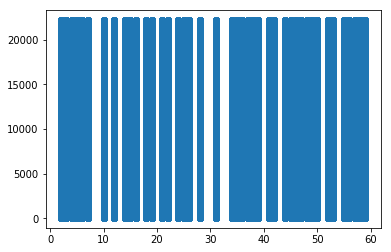

In [11]:
plt.scatter(test.shop_id, test.item_id)

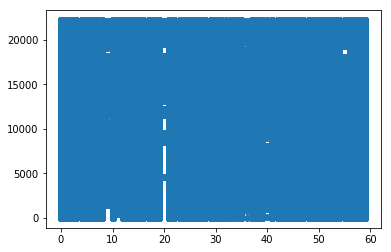

In [12]:
plt.scatter(train.shop_id, train.item_id)  # Test has fewer shops than train

In [5]:
# Remove the shops that are not in test
shops_to_drop = set(train.shop_id.unique()) - set(test.shop_id.unique())

In [6]:
train2 = train[~train.shop_id.isin(shops_to_drop)]
dropped_shops = train[train.shop_id.isin(shops_to_drop)]

In [7]:
print(train2.shape)
train2.shop_id.nunique()

(2413246, 6)


42

In [8]:
# pickle.dump(train2, open(r'../data2/train_42shops.pkl','wb'))
# pickle.dump(dropped_shops,open(r'../data2/dropped_18shops.pkl','wb'))
del dropped_shops
del train

### Basic exploratory (dtypes, nulls, and a simple submission)

In [9]:
train2.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [10]:
train2.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [11]:
train2['date2'] = pd.to_datetime(train2.date,format='%d.%m.%Y')

In [12]:
train2['month'] = train2.date2.dt.month

In [13]:
train2[:3]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date2,month
0,02.01.2013,0,59,22154,999.0,1.0,2013-01-02,1
1,03.01.2013,0,25,2552,899.0,1.0,2013-01-03,1
2,05.01.2013,0,25,2552,899.0,-1.0,2013-01-05,1


In [14]:
## Try to predict with the mean of each shop/item/month
shop_item_sales = train2.groupby(['shop_id','item_id']).agg({'item_cnt_day':'sum','date_block_num':'count'}).reset_index()
shop_item_sales['monthly_sales'] = shop_item_sales['item_cnt_day']/shop_item_sales['date_block_num']
shop_item_sales[:3]

,shop_id,item_id,item_cnt_day,date_block_num,monthly_sales
0,2,27,2.0,2,1.0
1,2,30,4.0,4,1.0
2,2,31,8.0,8,1.0


In [15]:
result = pd.merge(test,shop_item_sales,how='left')
result[:3]  

,ID,shop_id,item_id,item_cnt_day,date_block_num,monthly_sales
0,0,5,5037,13.0,13.0,1.000000
1,1,5,5320,NaN,NaN,NaN
2,2,5,5233,10.0,9.0,1.111111


In [16]:
result.monthly_sales.isnull().sum()  # Ok.. so half of the shop_item combo in test is not in train...

102796

In [17]:
# For the purpose of submission, just fill in global mean for now
shop_item_sales.monthly_sales.mean()

1.0553791881077363

In [22]:
result.loc[result.monthly_sales.isnull(), 'monthly_sales'] = 0 #shop_item_sales.monthly_sales.mean()

In [48]:
result['monthly_sales'].describe()

count    214200.000000
mean          0.562091
std           1.560323
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max         666.666667
Name: monthly_sales, dtype: float64

In [38]:
out_df = result[['ID','monthly_sales']]
out_df.rename(columns={'monthly_sales':'item_cnt_month'},inplace=True)
# out_df[:3]
out_df.to_csv(r'../output/4_1002_mean_by_shop_item_month_fill0.csv',index=False)

/Users/xiaoyu7016/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


#### Reproduce previous_value_benchmark

In [19]:
train2.date_block_num.max()

33

In [20]:
train3 = train2[train2.date_block_num==33]
train3.shape

(51822, 8)

In [26]:
prev_month = train3.groupby(['shop_id','item_id'])['item_cnt_day'].sum().reset_index()

In [32]:
result2 = pd.merge(test,prev_month,how='left')
result2[:3]

,ID,shop_id,item_id,item_cnt_day
0,0,5,5037,NaN
1,1,5,5320,NaN
2,2,5,5233,1.0


In [33]:
result2['item_cnt_day'].isnull().sum()  # =-= even more NAs

185520

In [35]:
result2.item_cnt_day.describe()

count    28680.000000
mean         2.191388
std         15.032652
min         -1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       2253.000000
Name: item_cnt_day, dtype: float64

In [40]:
result2.loc[result2.item_cnt_day>20,'item_cnt_day']=20
result2.fillna(0,inplace=True)
result2.rename(columns={'item_cnt_day':'item_cnt_month'},inplace=True)

In [41]:
result2[['ID','item_cnt_month']].to_csv(r'../output/5_1002_previous_value_benchmark.csv',index=False)